In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob

BASE = "/content/drive/MyDrive/dataset"
img_dir = os.path.join(BASE, "Images", "all_images")
lbl_dir = os.path.join(BASE, "labels", "all_images")

print("Images örnek:", glob.glob(img_dir+"/*")[:3])
print("Labels örnek:", glob.glob(lbl_dir+"/*.txt")[:3])
print("Toplam image:", len(glob.glob(img_dir+"/*")))
print("Toplam label:", len(glob.glob(lbl_dir+"/*.txt")))

Images örnek: ['/content/drive/MyDrive/dataset/Images/all_images/WhatsApp Image 2025-12-09 at 18.51.23 (1).jpeg', '/content/drive/MyDrive/dataset/Images/all_images/WhatsApp Image 2025-12-09 at 18.51.22.jpeg', '/content/drive/MyDrive/dataset/Images/all_images/WhatsApp Image 2025-12-09 at 18.51.23.jpeg']
Labels örnek: ['/content/drive/MyDrive/dataset/labels/all_images/WhatsApp Image 2025-12-09 at 18.51.22 (1).txt', '/content/drive/MyDrive/dataset/labels/all_images/WhatsApp Image 2025-12-09 at 18.51.22.txt', '/content/drive/MyDrive/dataset/labels/all_images/WhatsApp Image 2025-12-09 at 18.51.23 (1).txt']
Toplam image: 248
Toplam label: 248


In [ ]:
import os

# -------------------------------------------------------
# Bu kodun amacı:
# LabelImg ile etiketlenen YOLO formatındaki .txt dosyalarında
# yanlış sınıf ID'lerini, YOLOv8'e uygun hale getirmektir.
#
# LabelImg sırasında sınıflar:
# 15 -> dis_fircasi
# 16 -> dis_macunu
# olarak işaretlenmiştir.
#
# Ancak YOLOv8, sınıf indekslerinin 0'dan başlamasını ister.
# Bu nedenle aşağıdaki dönüşüm yapılır:
#
# 15 -> 0 (dis_fircasi)
# 16 -> 1 (dis_macunu)
# -------------------------------------------------------

changed_files = 0  # Kaç label dosyasının değiştirildiğini saymak için sayaç

# Label (.txt) dosyalarının bulunduğu klasördeki tüm dosyaları gez
for file in os.listdir(lbl_dir):

    # .txt olmayan dosyaları atla
    if not file.endswith(".txt"):
        continue

    # classes.txt dosyası YOLO etiket dosyası olmadığı için hariç tutulur
    if file.lower() == "classes.txt":
        continue

    # Dosyanın tam yolunu oluştur
    path = os.path.join(lbl_dir, file)

    # Etiket dosyasını oku
    with open(path, "r") as f:
        lines = f.readlines()

    new_lines = []     # Güncellenmiş etiket satırlarını tutacak liste
    changed = False    # Bu dosyada değişiklik yapıldı mı kontrolü

    # Dosyadaki her satırı işle
    for line in lines:
        # Satırı parçala (class_id x_center y_center width height)
        parts = line.strip().split()

        # Boş satır varsa atla
        if not parts:
            continue

        # Eğer sınıf ID 15 ise -> 0 yap (dis_fircasi)
        if parts[0] == "15":
            parts[0] = "0"
            changed = True

        # Eğer sınıf ID 16 ise -> 1 yap (dis_macunu)
        elif parts[0] == "16":
            parts[0] = "1"
            changed = True

        # Güncellenmiş satırı listeye ekle
        new_lines.append(" ".join(parts))

    # Eğer bu dosyada değişiklik yapıldıysa dosyayı yeniden yaz
    if changed:
        with open(path, "w") as f:
            f.write("\n".join(new_lines) + ("\n" if new_lines else ""))
        changed_files += 1  # Değiştirilen dosya sayısını artır

# İşlem sonunda kullanıcıya bilgi ver
print(f"Dönüştürülen label dosyası sayısı: {changed_files}")

✅ Dönüştürülen label dosyası: 248


In [ ]:
import os

# -------------------------------------------------------
# Bu kodun amacı:
# Görüntü (.jpg/.png) dosyaları ile onlara ait label (.txt)
# dosyalarının isimlerini düzenli ve sıralı hale getirmektir.
#
# Amaç:
# - YOLO eğitiminde dosya isim karmaşasını önlemek
# - Görsel ve label eşleşmesini garanti altına almak
# - image_0001.jpg, image_0001.txt gibi standart bir yapı oluşturmak
#
# NOT:
# img_dir ve lbl_dir değişkenleri daha önce tanımlanmıştır.
# -------------------------------------------------------

img_dir = img_dir   # Görsellerin bulunduğu klasör
lbl_dir = lbl_dir   # Label (.txt) dosyalarının bulunduğu klasör

# -------------------------------------------------------
# Klasördeki geçerli görsel dosyalarını al
# Sadece jpg, jpeg ve png uzantılı dosyalar işleme dahil edilir
# -------------------------------------------------------
images = sorted([
    f for f in os.listdir(img_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])

counter = 1   # Yeni isimlendirme için sayaç (image_0001, image_0002, ...)
renamed = 0   # Başarıyla yeniden adlandırılan dosya sayısı
skipped = 0   # Label dosyası bulunamadığı için atlanan görseller

# -------------------------------------------------------
# Her görsel için kontrol ve yeniden adlandırma işlemi
# -------------------------------------------------------
for img in images:
    # Dosya adını ve uzantısını ayır (örnek: foto.jpg -> foto, .jpg)
    base, ext = os.path.splitext(img)

    # Görsele karşılık gelmesi gereken label dosyası
    label_file = base + ".txt"

    # ---------------------------------------------------
    # Eğer görselin label dosyası yoksa:
    # - Bu görsel atlanır
    # - Sayaç artırılmaz
    # ---------------------------------------------------
    if not os.path.exists(os.path.join(lbl_dir, label_file)):
        skipped += 1
        continue

    # Yeni dosya adı oluşturulur (image_0001 gibi)
    new_name = f"image_{counter:04d}"

    # Eski dosya yolları
    old_img_path = os.path.join(img_dir, img)
    old_lbl_path = os.path.join(lbl_dir, label_file)

    # Yeni dosya yolları
    new_img_path = os.path.join(img_dir, new_name + ext.lower())
    new_lbl_path = os.path.join(lbl_dir, new_name + ".txt")

    # ---------------------------------------------------
    # Görsel ve label dosyaları aynı anda yeniden adlandırılır
    # Böylece eşleşme bozulmaz
    # ---------------------------------------------------
    os.rename(old_img_path, new_img_path)
    os.rename(old_lbl_path, new_lbl_path)

    counter += 1   # Bir sonraki dosya numarasına geç
    renamed += 1   # Başarılı işlem sayısını artır

# -------------------------------------------------------
# İşlem sonunda kullanıcıya özet bilgi verilir
# -------------------------------------------------------
print(" Yeniden adlandırılan görsel-label çifti:", renamed)
print(" Label dosyası olmadığı için atlanan görsel sayısı:", skipped)


✅ Yeniden adlandırılan çift: 248
⚠️ Atlanan (label yok): 0


In [ ]:
import os
import glob
import random
import shutil

# -------------------------------------------------------
# Bu kodun amacı:
# Tüm görselleri ve etiketlerini (labels) YOLOv8 formatına
# uygun şekilde Train / Validation olarak ayırmaktır.
#
# Yapılan işlem:
# - Tüm görseller tek klasörden alınır
# - Rastgele karıştırılır
# - %80 Train, %20 Validation olacak şekilde bölünür
# - Görsel + label çiftleri doğru klasörlere kopyalanır
#
# Bu işlem, modelin genelleme başarısını ölçebilmek için
# zorunlu bir adımdır.
# -------------------------------------------------------

# -------------------------------------------------------
# Kaynak klasörler
# -------------------------------------------------------
IMG_SRC = "/content/drive/MyDrive/dataset/Images/all_images"
LBL_SRC = "/content/drive/MyDrive/dataset/labels/all_images"

# -------------------------------------------------------
# Hedef YOLOv8 dataset ana klasörü
# -------------------------------------------------------
OUT = "/content/drive/MyDrive/dataset_yolo"

# YOLOv8'in beklediği klasör yapısı
IMG_TRAIN = os.path.join(OUT, "images/train")
IMG_VAL   = os.path.join(OUT, "images/val")
LBL_TRAIN = os.path.join(OUT, "labels/train")
LBL_VAL   = os.path.join(OUT, "labels/val")

# -------------------------------------------------------
# Gerekli klasörleri oluştur
# exist_ok=True sayesinde klasör varsa hata verilmez
# -------------------------------------------------------
for p in [IMG_TRAIN, IMG_VAL, LBL_TRAIN, LBL_VAL]:
    os.makedirs(p, exist_ok=True)

# -------------------------------------------------------
# Kaynak klasördeki tüm görselleri al
# Sadece .jpg, .jpeg ve .png uzantılı dosyalar dahil edilir
# -------------------------------------------------------
images = sorted([
    p for p in glob.glob(os.path.join(IMG_SRC, "*"))
    if p.lower().endswith((".jpg", ".jpeg", ".png"))
])

print("Toplam görsel:", len(images))

# -------------------------------------------------------
# Rastgelelik (Randomness) kontrolü
# seed(42) kullanarak her çalıştırmada
# aynı train/val ayrımının yapılması sağlanır
# -------------------------------------------------------
random.seed(42)
random.shuffle(images)

# -------------------------------------------------------
# %80 Train / %20 Validation bölünmesi
# -------------------------------------------------------
split_idx = int(len(images) * 0.8)
train_imgs = images[:split_idx]
val_imgs   = images[split_idx:]

# -------------------------------------------------------
# Görsel + label çiftini kopyalayan yardımcı fonksiyon
# -------------------------------------------------------
def copy_pair(img_path, img_dst, lbl_dst):
    # Dosya adını al (image_0001.jpg -> image_0001)
    base = os.path.splitext(os.path.basename(img_path))[0]

    # Karşılık gelen label dosyası
    lbl_path = os.path.join(LBL_SRC, base + ".txt")

    # Eğer label yoksa işlem yapılmaz
    if not os.path.exists(lbl_path):
        return False

    # Görseli hedef klasöre kopyala
    shutil.copy2(img_path, os.path.join(img_dst, os.path.basename(img_path)))

    # Label dosyasını hedef klasöre kopyala
    shutil.copy2(lbl_path, os.path.join(lbl_dst, base + ".txt"))

    return True

missing = 0  # Label dosyası bulunamayan görsellerin sayısı

# -------------------------------------------------------
# Train seti için kopyalama işlemi
# -------------------------------------------------------
for img in train_imgs:
    if not copy_pair(img, IMG_TRAIN, LBL_TRAIN):
        missing += 1

# -------------------------------------------------------
# Validation seti için kopyalama işlemi
# -------------------------------------------------------
for img in val_imgs:
    if not copy_pair(img, IMG_VAL, LBL_VAL):
        missing += 1

# -------------------------------------------------------
# İşlem sonunda özet bilgiler
# -------------------------------------------------------
print(" Train image:", len(glob.glob(IMG_TRAIN + "/*")))
print(" Val image:", len(glob.glob(IMG_VAL + "/*")))
print(" Label'i olmayan görsel:", missing)


Toplam görsel: 248
✅ Train image: 198
✅ Val image: 50
⚠️ Label'i olmayan görsel: 0


In [ ]:
import os

# -------------------------------------------------------
# Bu kodun amacı:
# YOLOv8 model eğitimi sırasında kullanılan data.yaml
# dosyasını otomatik olarak oluşturmak ve kaydetmektir.
#
# data.yaml dosyası, YOLOv8'in:
# - Veri setinin nerede olduğunu
# - Eğitim ve doğrulama klasörlerini
# - Kaç sınıf olduğunu
# - Sınıf isimlerini
# bilmesini sağlar.
#
# Bu dosya olmadan YOLOv8 eğitimi başlatılamaz.
# -------------------------------------------------------

# YOLO formatına dönüştürülmüş veri setinin ana dizini
DATASET_YOLO = "/content/drive/MyDrive/dataset_yolo"

# -------------------------------------------------------
# data.yaml dosyasının içeriği
# f-string kullanılarak dataset yolu dinamik hale getirilmiştir
# -------------------------------------------------------
yaml_content = f"""path: {DATASET_YOLO}
train: images/train
val: images/val

nc: 2
names:
  - dis_fircasi
  - dis_macunu
"""

# -------------------------------------------------------
# data.yaml dosyasının kaydedileceği tam dosya yolu
# -------------------------------------------------------
yaml_path = os.path.join(DATASET_YOLO, "data.yaml")

# -------------------------------------------------------
# data.yaml dosyasını yazma işlemi
# Eğer dosya yoksa oluşturulur, varsa üzerine yazılır
# -------------------------------------------------------
with open(yaml_path, "w") as f:
    f.write(yaml_content)

# -------------------------------------------------------
# Kullanıcıya bilgi amaçlı çıktı
# -------------------------------------------------------
print(" data.yaml oluşturuldu:")
print(yaml_content)


✅ data.yaml oluşturuldu:
path: /content/drive/MyDrive/dataset_yolo
train: images/train
val: images/val

nc: 2
names:
  - dis_fircasi
  - dis_macunu



BU DOSYA NE İŞE YARIYOR? (Sözlüde sorulursa)

“data.yaml, YOLOv8’e veri setinin nerede olduğunu, kaç sınıf olduğunu ve sınıf isimlerini söyler.”

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.7 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# -------------------------------------------------------
# Bu kodun amacı:
# Hazırlanan YOLO formatındaki veri seti kullanılarak
# YOLOv8 modelinin eğitilmesini başlatmaktır.
#
# Eğitim sırasında:
# - data.yaml dosyası okunur
# - Belirlenen epoch sayısı kadar eğitim yapılır
# - Model ağırlıkları ve loglar belirtilen klasöre kaydedilir
#
# Bu adım, projenin en kritik aşamasıdır.
# -------------------------------------------------------

# YOLO veri seti yapılandırma dosyasının yolu
DATA_YAML = "/content/drive/MyDrive/dataset_yolo/data.yaml"

# -------------------------------------------------------
# Model eğitiminin başlatılması
# -------------------------------------------------------
results = model.train(
    data=DATA_YAML,        # Eğitim ve doğrulama veri yollarını içeren YAML dosyası
    epochs=50,             # Modelin veri seti üzerinde kaç kez eğitileceği
    imgsz=640,             # Eğitim sırasında kullanılan giriş görüntü boyutu (640x640)
    batch=16,              # Her adımda modele verilen görüntü sayısı
    workers=2,             # Veri yükleme işlemi için kullanılan paralel işlem sayısı
    project="/content/drive/MyDrive/yolo_runs",  # Eğitim çıktılarının kaydedileceği ana klasör
    name="dis_seti_v1",     # Bu eğitim koşusuna verilen isim
    exist_ok=True          # Aynı isimli klasör varsa üzerine yazılmasına izin verir
)

# -------------------------------------------------------
# Eğitim tamamlandığında:
# - En iyi model ağırlıkları best.pt olarak kaydedilir
# - Eğitim ve doğrulama metrikleri run klasöründe tutulur
# -------------------------------------------------------


Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/dataset_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dis_seti_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0

In [ ]:
import os

best_path = "/content/drive/MyDrive/yolo_runs/dis_seti_v1/weights/best.pt"
print("best.pt var mı?", os.path.exists(best_path))
print("Konum:", best_path)


best.pt var mı? True
Konum: /content/drive/MyDrive/yolo_runs/dis_seti_v1/weights/best.pt


In [ ]:
import glob
import random

TEST_IMAGES = glob.glob("/content/drive/MyDrive/dataset_yolo/images/val/*")
test_img = random.choice(TEST_IMAGES)

print("Test görseli:", test_img)

Test görseli: /content/drive/MyDrive/dataset_yolo/images/val/image_0229.jpeg


In [ ]:
from ultralytics import YOLO

# -------------------------------------------------------
# Bu kodun amacı:
# Daha önce eğitilmiş ve en iyi performansa sahip olduğu
# belirlenen YOLOv8 modelini (best.pt) yükleyerek,
# yeni bir test görüntüsü üzerinde nesne tespiti yapmaktır.
#
# Bu aşama, modelin gerçek görüntüler üzerindeki
# başarımını gözlemlemek için kullanılır.
# -------------------------------------------------------

# -------------------------------------------------------
# Eğitilmiş model ağırlıklarının (best.pt) yüklenmesi
# -------------------------------------------------------
model = YOLO("/content/drive/MyDrive/yolo_runs/dis_seti_v1/weights/best.pt")

# -------------------------------------------------------
# Model ile tahmin (prediction / inference) işlemi
# -------------------------------------------------------
results = model.predict(
    source=test_img,   # Test edilecek görselin dosya yolu veya değişkeni
    conf=0.25,         # Minimum güven skoru (confidence threshold)
                       # 0.25'in altındaki tespitler dikkate alınmaz
    save=True          # Tahmin sonucunda oluşan görsellerin diske kaydedilmesi
)

# -------------------------------------------------------
# Tahmin işlemi sonucunda:
# - Görsel üzerinde tespit edilen nesneler bounding box ile işaretlenir
# - Sonuç görselleri varsayılan runs/predict klasörüne kaydedilir
# - results değişkeni içinde tespit bilgileri (sınıf, skor, bbox) tutulur
# -------------------------------------------------------



image 1/1 /content/drive/MyDrive/dataset_yolo/images/val/image_0229.jpeg: 640x480 1 dis_macunu, 39.7ms
Speed: 2.4ms preprocess, 39.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/runs/detect/predict


In [ ]:
import os
os.listdir("/content/runs/detect/predict")

['image_0229.jpg']

(np.float64(-0.5), np.float64(1199.5), np.float64(1599.5), np.float64(-0.5))

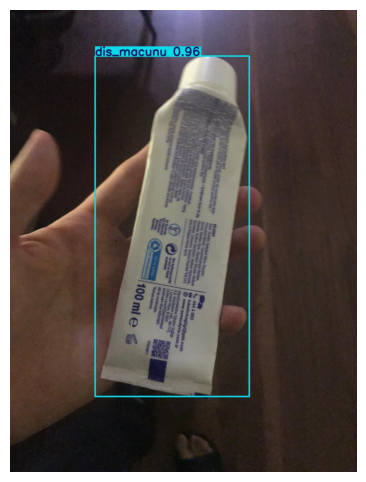

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

output_img = "/content/runs/detect/predict/" + os.listdir("/content/runs/detect/predict")[0]

img = Image.open(output_img)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")